In [1]:
"""
In this nb, we are forecasting Time-Series with a Stateful LSTM(Long Short Term Memory) Model with CNN. 
Then, we see the Fully Convolutional Model which ends up being the best model so far to predict Time
Series.
"""

# Importing stuff
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

# A function to plot time-series. This will be called finally when complete series is built
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end],series[start:end],format,label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
# Function to create a trend
def trend(time,slope=0):
    return slope*time

# Creating a time series
time = np.arange(4*365+1)
baseline = 10 #Base value for trend 

# Function which creates a random pattern. This pattern will be repeated to get a seasonal pattern
def seasonal_pattern(seasonal_time):
    return np.where(seasonal_time < 0.4,
                    1/np.exp(3*seasonal_time),
                    np.cos(seasonal_time*2*np.pi))

# Function to repeat seasonal pattern
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase) % period)/period
    return amplitude * seasonal_pattern(season_time)

# Function to create white noise. seed parameter here is used by random number generator as a base to create
# random number. When it is None, rnd will use system time as seed. But, if we give some constant value like 42,
# then every time same noise will be generated. Thus, to get different noise everytime keep seed as None even 
# while calling the function
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Creating Seasonality 
amplitude = 50
series = seasonality(time,period=365,amplitude=amplitude) + baseline

# Creating White Noise
noise_level = 5
noise = white_noise(time,noise_level)

# Creating seasonality with trend
slope = 0.05
series = baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)

# Finally plotting complete time-series
series += noise
plt.figure(figsize=(10,10))
plot_series(time,series,label="Time-Series")

# Creating Training and Validation data
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Function to apply our model to series(This will be validation series)
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [2]:
# Function to create dataset in proper format for Seq2Seq Model
def seq2seq_window_dataset(series,window_size=30,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x: (x[:-1],x[1:]))
    return ds.batch(batch_size).prefetch(1)

Epoch 1/100
8/8 [==============================] - 8s 1s/step - loss: 53.7102 - mae: 54.7196
Epoch 2/100
8/8 [==============================] - 2s 225ms/step - loss: 52.0676 - mae: 52.6177
Epoch 3/100
8/8 [==============================] - 2s 209ms/step - loss: 48.7645 - mae: 49.0489
Epoch 4/100
8/8 [==============================] - 2s 298ms/step - loss: 40.8932 - mae: 41.0552
Epoch 5/100
8/8 [==============================] - 2s 234ms/step - loss: 28.7390 - mae: 28.9648
Epoch 6/100
8/8 [==============================] - 2s 198ms/step - loss: 23.6893 - mae: 24.0139
Epoch 7/100
8/8 [==============================] - 2s 292ms/step - loss: 21.9117 - mae: 22.4163
Epoch 8/100
8/8 [==============================] - 2s 193ms/step - loss: 21.4321 - mae: 21.9046
Epoch 9/100
8/8 [==============================] - 1s 185ms/step - loss: 20.9653 - mae: 21.5762
Epoch 10/100
8/8 [==============================] - 2s 202ms/step - loss: 20.9369 - mae: 21.2313
Epoch 11/100
8/8 [========================

8/8 [==============================] - 2s 193ms/step - loss: 16.3986 - mae: 16.5174
Epoch 87/100
8/8 [==============================] - 1s 184ms/step - loss: 8.7739 - mae: 9.3322
Epoch 88/100
8/8 [==============================] - 1s 180ms/step - loss: 8.2486 - mae: 8.6738
Epoch 89/100
8/8 [==============================] - 2s 192ms/step - loss: 9.8162 - mae: 10.0213
Epoch 90/100
8/8 [==============================] - 1s 180ms/step - loss: 9.1256 - mae: 9.7006
Epoch 91/100
8/8 [==============================] - 2s 190ms/step - loss: 8.1774 - mae: 9.2323
Epoch 92/100
8/8 [==============================] - 2s 190ms/step - loss: 9.5813 - mae: 10.2360
Epoch 93/100
8/8 [==============================] - 1s 183ms/step - loss: 7.9034 - mae: 9.0915
Epoch 94/100
8/8 [==============================] - 1s 186ms/step - loss: 11.4054 - mae: 11.6272
Epoch 95/100
8/8 [==============================] - 1s 179ms/step - loss: 12.8483 - mae: 12.9934
Epoch 96/100
8/8 [==============================] - 1s 

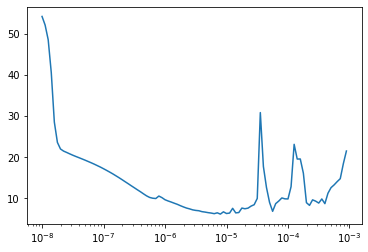

In [4]:
# Building the model Con1D followed by LSTM Architecture
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train,window_size, batch_size=128)

# Stateful LSTM Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
# stateful = True makes sure that the state of previous batch goes to the next one
model = tf.keras.Sequential([
    keras.layers.Conv1D(filters=32, strides=1, kernel_size=5, input_shape=[None,1], activation="relu",
                       padding="causal"),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

plt.semilogx(history.history['lr'],history.history['loss'])

In [6]:
# Building the model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train,window_size)
valid_set = seq2seq_window_dataset(x_valid,window_size)

# Simple RNN Model, return_sequences=True makes first Recurrent layer to return output for each time-stamp
# Recurrent layers need 3-d input_shape, [batch_size, number of time stamps, dimensionality of input]
# tf.expand_dims add one more dimension of 1 since we are using uni-variate time series.
# This is required because window_dataset creates 2-d dataset
# stateful = True makes sure that the state of previous batch goes to the next one
model = tf.keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation='relu', input_shape=[None,1]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0) #The output of RNN layers is normalised between [-1,1]
])

# Stops training if metric stays same for 50 epochs on valid_set
early_stopper = keras.callbacks.EarlyStopping(patience=50)

# Saves the best model(model with best parameters) as "my_checkpoint.h5" so that we can load this model at end
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only = True)

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,validation_data=valid_set,callbacks=[early_stopper])

Epoch 1/100
31/31 [==============================] - 11s 352ms/step - loss: 22.9594 - mae: 23.6416 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 3s 103ms/step - loss: 11.7174 - mae: 11.9001 - val_loss: 14.0729 - val_mae: 14.5213
Epoch 3/100
31/31 [==============================] - 4s 118ms/step - loss: 10.0304 - mae: 10.4351 - val_loss: 13.5132 - val_mae: 14.0497
Epoch 4/100
31/31 [==============================] - 3s 95ms/step - loss: 9.2610 - mae: 9.6055 - val_loss: 13.7457 - val_mae: 14.2124
Epoch 5/100
31/31 [==============================] - 3s 92ms/step - loss: 8.5458 - mae: 8.9506 - val_loss: 12.9544 - val_mae: 13.3379
Epoch 6/100
31/31 [==============================] - 3s 94ms/step - loss: 8.1188 - mae: 8.4602 - val_loss: 12.4429 - val_mae: 12.8882
Epoch 7/100
31/31 [==============================] - 3s 91ms/step - loss: 7.6163 - mae: 8.0852 - val_loss: 11.0057 - val_mae: 11.4885
Epoch 8/100
31/31 [===========================

31/31 [==============================] - 4s 139ms/step - loss: 5.2547 - mae: 5.7609 - val_loss: 6.7880 - val_mae: 7.2522
Epoch 63/100
31/31 [==============================] - 4s 145ms/step - loss: 5.2708 - mae: 5.7512 - val_loss: 6.8810 - val_mae: 7.3463
Epoch 64/100
31/31 [==============================] - 4s 140ms/step - loss: 5.2493 - mae: 5.7372 - val_loss: 7.0216 - val_mae: 7.5191
Epoch 65/100
31/31 [==============================] - 5s 149ms/step - loss: 5.2350 - mae: 5.7371 - val_loss: 6.4779 - val_mae: 6.9803
Epoch 66/100
31/31 [==============================] - 4s 144ms/step - loss: 5.2617 - mae: 5.7271 - val_loss: 6.7031 - val_mae: 7.2208
Epoch 67/100
31/31 [==============================] - 4s 142ms/step - loss: 5.2260 - mae: 5.7245 - val_loss: 6.7535 - val_mae: 7.2249
Epoch 68/100
31/31 [==============================] - 4s 138ms/step - loss: 5.2410 - mae: 5.7095 - val_loss: 6.9050 - val_mae: 7.3873
Epoch 69/100
31/31 [==============================] - 4s 143ms/step - loss:

In [7]:
model = keras.models.load_model("my_checkpoint.h5")

In [8]:
model.reset_states()
# We're forecasting on complete series and then cropping out only the validation part for plotting
rnn_forecast = model.predict(series[np.newaxis,:,np.newaxis])[0,split_time-1:-1,0]

4.5491962

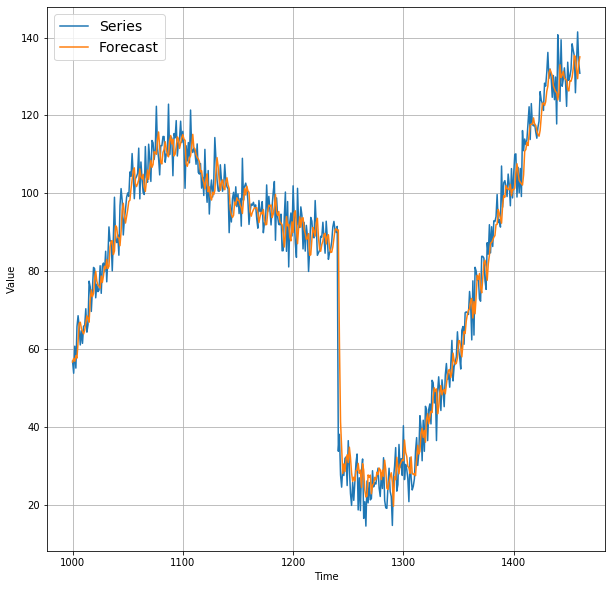

In [9]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,rnn_forecast,label="Forecast")

keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()
# MAE is 4.54 :)

Epoch 1/100
8/8 [==============================] - 3s 337ms/step - loss: 45.2803 - mae: 46.1531
Epoch 2/100
8/8 [==============================] - 0s 58ms/step - loss: 45.4524 - mae: 46.1530
Epoch 3/100
8/8 [==============================] - 0s 59ms/step - loss: 45.7390 - mae: 46.1530
Epoch 4/100
8/8 [==============================] - 0s 56ms/step - loss: 45.3605 - mae: 46.1528
Epoch 5/100
8/8 [==============================] - 0s 58ms/step - loss: 45.8235 - mae: 46.1527
Epoch 6/100
8/8 [==============================] - 1s 73ms/step - loss: 45.6920 - mae: 46.1525
Epoch 7/100
8/8 [==============================] - 1s 85ms/step - loss: 45.4847 - mae: 46.1524
Epoch 8/100
8/8 [==============================] - 1s 68ms/step - loss: 45.6440 - mae: 46.1522
Epoch 9/100
8/8 [==============================] - 0s 62ms/step - loss: 45.3839 - mae: 46.1520
Epoch 10/100
8/8 [==============================] - 0s 60ms/step - loss: 45.8719 - mae: 46.1517
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 0s 58ms/step - loss: 9.3903 - mae: 9.9234
Epoch 87/100
8/8 [==============================] - 0s 60ms/step - loss: 8.9864 - mae: 9.4580
Epoch 88/100
8/8 [==============================] - 0s 61ms/step - loss: 8.5331 - mae: 8.9977
Epoch 89/100
8/8 [==============================] - 0s 57ms/step - loss: 8.1391 - mae: 8.5936
Epoch 90/100
8/8 [==============================] - 0s 58ms/step - loss: 7.8659 - mae: 8.3260
Epoch 91/100
8/8 [==============================] - 0s 61ms/step - loss: 7.7023 - mae: 8.1665
Epoch 92/100
8/8 [==============================] - 0s 56ms/step - loss: 7.6091 - mae: 8.0567
Epoch 93/100
8/8 [==============================] - 0s 58ms/step - loss: 7.5515 - mae: 7.9590
Epoch 94/100
8/8 [==============================] - 0s 60ms/step - loss: 7.3706 - mae: 7.8757
Epoch 95/100
8/8 [==============================] - 0s 59ms/step - loss: 7.2972 - mae: 7.7991
Epoch 96/100
8/8 [==============================] - 0s 60ms/step - loss: 

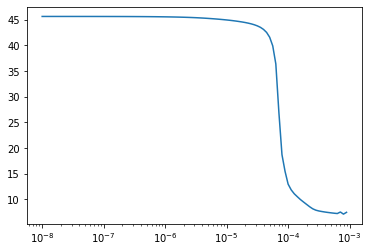

In [13]:
# Building the fully Convolutional Model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train,window_size, batch_size=128)

# Wavenet architecture with dilation_rate doubling for every Convolutional layer
model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=[None,1])])
for dilation_rate in (1,2,4,8,16,32):
    model.add(keras.layers.Conv1D(
                                 filters=32, kernel_size=2,
                                 strides=1, dilation_rate=dilation_rate,
                                 padding="causal", activation="relu")
                                 )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
    

# We can use Learning Rate Scheduler which can show us at which lr model is giving better results
# After every 30 epochs lr is * by 10 power and model is evaluated using it
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

plt.semilogx(history.history['lr'],history.history['loss'])

In [17]:
# Building the fully Convolutional Model
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = seq2seq_window_dataset(x_train,window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid,window_size, batch_size=128)

# Wavenet architecture with dilation_rate doubling for every Convolutional layer
model = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=[None,1])])
for dilation_rate in (1,2,4,8,16,32):
    model.add(keras.layers.Conv1D(
                                 filters=32, kernel_size=2,
                                 strides=1, dilation_rate=dilation_rate,
                                 padding="causal", activation="relu")
                                 )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
    

# Optimizer is Stochastic Gradient Descent
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

# Stops training if metric stays same for 50 epochs on valid_set
early_stopper = keras.callbacks.EarlyStopping(patience=50)

# Saves the best model(model with best parameters) as "my_checkpoint.h5" so that we can load this model at end
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only = True)

history = model.fit(train_set,validation_data=valid_set,epochs=100,callbacks=[early_stopper, model_checkpoint])

Epoch 1/100
8/8 [==============================] - 3s 359ms/step - loss: 44.3799 - mae: 45.2420 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 1s 76ms/step - loss: 44.1768 - mae: 44.9424 - val_loss: 79.6628 - val_mae: 80.3511
Epoch 3/100
8/8 [==============================] - 1s 76ms/step - loss: 44.2281 - mae: 44.3980 - val_loss: 78.6052 - val_mae: 78.8337
Epoch 4/100
8/8 [==============================] - 1s 75ms/step - loss: 42.6736 - mae: 43.5056 - val_loss: 75.8476 - val_mae: 76.3579
Epoch 5/100
8/8 [==============================] - 1s 76ms/step - loss: 42.1724 - mae: 41.8597 - val_loss: 70.8606 - val_mae: 70.9534
Epoch 6/100
8/8 [==============================] - 1s 78ms/step - loss: 38.0814 - mae: 37.7993 - val_loss: 55.2794 - val_mae: 56.0383
Epoch 7/100
8/8 [==============================] - 1s 75ms/step - loss: 26.6006 - mae: 25.2924 - val_loss: 30.0274 - val_mae: 30.1630
Epoch 8/100
8/8 [==============================] - 1s 8

8/8 [==============================] - 1s 87ms/step - loss: 6.9678 - mae: 7.5934 - val_loss: 4.8442 - val_mae: 5.3133
Epoch 64/100
8/8 [==============================] - 1s 79ms/step - loss: 7.0409 - mae: 7.5820 - val_loss: 4.8208 - val_mae: 5.3044
Epoch 65/100
8/8 [==============================] - 1s 79ms/step - loss: 7.0208 - mae: 7.5700 - val_loss: 4.8261 - val_mae: 5.2886
Epoch 66/100
8/8 [==============================] - 1s 72ms/step - loss: 7.1479 - mae: 7.5588 - val_loss: 4.8284 - val_mae: 5.2838
Epoch 67/100
8/8 [==============================] - 1s 84ms/step - loss: 6.8806 - mae: 7.5492 - val_loss: 4.8008 - val_mae: 5.2774
Epoch 68/100
8/8 [==============================] - 1s 80ms/step - loss: 6.9868 - mae: 7.5378 - val_loss: 4.7592 - val_mae: 5.2528
Epoch 69/100
8/8 [==============================] - 1s 77ms/step - loss: 6.9716 - mae: 7.5282 - val_loss: 4.7859 - val_mae: 5.2421
Epoch 70/100
8/8 [==============================] - 1s 83ms/step - loss: 6.9645 - mae: 7.5182 - 

In [18]:
model = keras.models.load_model("my_checkpoint.h5")

In [19]:
model.reset_states()
# We're forecasting on complete series and then cropping out only the validation part for plotting
cnn_forecast = model.predict(series[np.newaxis,:,np.newaxis])[0,split_time-1:-1,0]

4.5491962

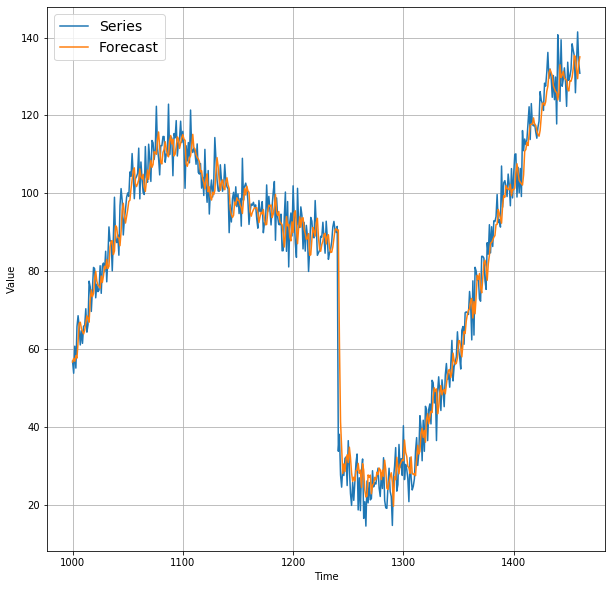

In [21]:
plt.figure(figsize=(10,10))
plot_series(time_valid,x_valid,label="Series")
plot_series(time_valid,rnn_forecast,label="Forecast")

keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()
# MAE is 4.54 :) Best Model So far